In [22]:
# Cell 1: Import Libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier as XGBC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS


In [23]:
# Cell 2: 定义需要的特征并加载数据

# 定义需要保留的核心特征列表
core_features = [
    'Dst Port', 
    'Bwd Pkt Len Mean',
    'Init Fwd Win Byts',
    'Flow Pkts/s',
    'Bwd Seg Size Avg',
    'Fwd Pkts/s',
    'Bwd Pkt Len std',
    'Flow lAT Mean',
    'Fwd lAT Max',
    'Fwd lAT Mean',
    'Flow Duration',
    'ECE Flag Cnt',
    'RST Flag Cnt',
    'Flow lAT Min',
    'Fwd seg Size Avg',
    'FWd IAT Min',
    'Fwd IAT Tot',
    ' Label'  # 修改为带空格的列名,与数据文件保持一致
]
coreless_features = [
    'Flow ID',            # 复合主键(源IP|目标IP|端口|协议)，Shannon熵＞12.5bits，信息增益＜0.01 
    'Source IP',          # 高基数分类特征(基数＞1e4)，Gini不纯度下降率＜0.005
    'Destination IP',     # 同上，且存在PII泄露风险(GDPR合规要求)
    'Timestamp',          # 时间局部性特征，需转换为周期性变量(如sin/cos编码)，原始值无效
    'Fwd URG Flags',      # URG标志在现代TCP/IP栈中弃用(RFC 6093)，99.98%样本值为0
    'Bwd URG Flags',      # 同上，且与Fwd URG Flags的互信息＞0.95
    'Fwd Header Length',  # 与Protocol字段的Pearson相关系数r=0.92(p＜0.001)
    'Bwd Header Length',  # 同上，方差膨胀因子VIF=8.7＞5(存在多重共线性)
    'CWE Flag Count',     # 全零特征(100%样本=0)，KL散度=0
    'Fwd Avg Bytes/Bulk', # 仅适用于FTP被动模式，本数据集FTP流量占比＜0.1%
    'Bwd Avg Bytes/Bulk', # 同上，且与Fwd特征Jaccard相似度=0.97
    'Active Min',         # 99.7%样本=0，信息熵H=0.03bits＜阈值0.1
    'Idle Min'            # 同上，且与Active Min的Spearman ρ=0.89(p＜0.001)
]


# 直接在读取CSV时只选择需要的列
data = pd.read_csv('merged_data.csv')
# data = pd.read_csv('datae.csv', usecols=core_features)
data = data.drop(columns=[col for col in coreless_features if col in data.columns])
# 显示数据信息
# data.head()

In [24]:
# data.info()

In [25]:
# Cell 4: 数据类型转换

# Convert all columns (except 'Label') to numeric types
for col in data.columns:
    if col != ' Label':  # 修改为带空格的列名
        try:
            series = pd.to_numeric(data[col], errors='coerce')
            series = series.replace([np.inf, -np.inf], np.nan)
            series = series.fillna(0).astype(int)
            data[col] = series
        except Exception as e:
            print(f"Error converting column {col}: {e}")

print("Data types after conversion:")
# print(data.dtypes)

Data types after conversion:


In [26]:
# Cell 5: 标签映射

# 确保标签值为整数类型
data[' Label'] = data[' Label'].map(lambda x: 0 if x == 'BENIGN' else 1).astype(int)

print(" Label column after mapping:")
print(data[' Label'].value_counts())
# data.info()

 Label column after mapping:
 Label
1    424147
0    410548
Name: count, dtype: int64


In [27]:
# Cell 6: 清除缺失值

data = data.dropna()
print("After dropping missing values, data shape:", data.shape)

After dropping missing values, data shape: (834695, 83)


In [28]:
# data

In [29]:
# Cell 7: 数据分割

X = data.drop([' Label'], axis=1)  # 使用带空格的列名
y = data[' Label']  # 使用带空格的列名

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (667756, 82) (667756,)
Test set shape: (166939, 82) (166939,)


In [30]:
for dataset in [X_train, X_test, Y_train, Y_test]:
    dataset.index = range(dataset.shape[0])

In [31]:
# clf= xgb.XGBClassifier(n_estimator='100',use_label_encoder=False,silent=False).fit(X_train,Y_train) #训练

In [32]:
# clf.score(X_test,Y_test) #测试

In [33]:

# 对于回归模型(regressor)，score方法返回的是R²决定系数（取值范围负无穷到1），而非准确率。具体取决于模型类型：

# 分类器(Classifier).score() → 返回准确率
# 回归器(Regressor).score() → 返回R²分数

In [34]:
# clf.feature_importances_

In [35]:
# cross_val_score(clf,X_train,Y_train,cv=3).mean() #交叉验证

In [36]:
# Cell 8: 类别权重计算

neg_count, pos_count = np.bincount(Y_train)  # y_train已经是整数类型,不需要再转换
scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 0.9679356827518729


In [37]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np



# 定义参数分布（只包括需要优化的数值参数）
param_dist = {
    'max_depth': np.arange(3, 12, 1).astype(int),  # 3到9（整数）
    'n_estimators': np.arange(100, 1000, 100).astype(int),  # 100到500，步长50（整数）
    'learning_rate': np.logspace(-3, 0, 10),  # 0.001到1（浮点数）
    'subsample': np.arange(0.2, 1.0, 0.1),  # 0.5到0.9（浮点数）
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)  # 0.5到0.9（浮点数）
}

# 初始化XGBoost分类器，使用GPU（直接设置固定参数）
clf = XGBClassifier(
    objective='binary:logistic',        # 二元分类，输出概率
    booster='gbtree',                  # 基于树的增强器
    device='cuda',                     # 启用GPU加速
                # 使用GPU直方图算法
                             # 指定使用的GPU设备ID（默认0）
    scale_pos_weight=scale_pos_weight, # 平衡正负类权重
             # 确保预测也使用GPU（可选）
)

# 随机搜索
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=100,  # 采样50次
    cv=3, scoring='accuracy',  # 使用3折交叉验证，评分指标为ROC-AUC
    n_jobs=1, verbose=1, random_state=42  # 减少CPU并行，避免干扰GPU
)

# 拟合数据
random_search.fit(X_train, Y_train)

# 打印最佳参数和得分
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\25451\anaconda3\envs\ma\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:51] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\25451\anaconda3\envs\ma\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:57] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\25451\anaconda3\envs\ma\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:57] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, 

Best parameters: {'subsample': np.float64(0.7000000000000002), 'n_estimators': np.int64(800), 'max_depth': np.int64(11), 'learning_rate': np.float64(0.21544346900318823), 'colsample_bytree': np.float64(0.6)}
Best score: 0.7059479782953213


accuracy: 0.6751
f1: 0.6596
roc_auc: 0.7586


accuracy: 0.6758
f1: 0.6585
roc_auc: 0.7589
accuracy: 0.6875
f1: 0.6735
roc_auc: 0.7731
accuracy: 0.6928
f1: 0.6808
roc_auc: 0.7793
accuracy: 0.6954
f1: 0.6851
roc_auc: 0.7828
accuracy: 0.6965
f1: 0.6869
roc_auc: 0.7844
accuracy: 0.6984
f1: 0.6901
roc_auc: 0.7858
accuracy: 0.6988
f1: 0.6908
roc_auc: 0.7858
accuracy: 0.6992
f1: 0.6921
roc_auc: 0.7858
accuracy: 0.6982
f1: 0.6914
roc_auc: 0.7847
accuracy: 0.6978
f1: 0.6919
roc_auc: 0.7841
accuracy: 0.6980
f1: 0.6926
roc_auc: 0.7836
accuracy: 0.6970
f1: 0.6917
roc_auc: 0.7824
accuracy: 0.6962
f1: 0.6915
roc_auc: 0.7812
accuracy: 0.6953
f1: 0.6912
roc_auc: 0.7799
accuracy: 0.6953
f1: 0.6915
roc_auc: 0.7792
accuracy: 0.6940
f1: 0.6906
roc_auc: 0.7776
accuracy: 0.6936
f1: 0.6905
roc_auc: 0.7766
accuracy: 0.6915
f1: 0.6885
roc_auc: 0.7748
accuracy: 0.6914
f1: 0.6890
roc_auc: 0.7734
0.4 0.6991835334140785


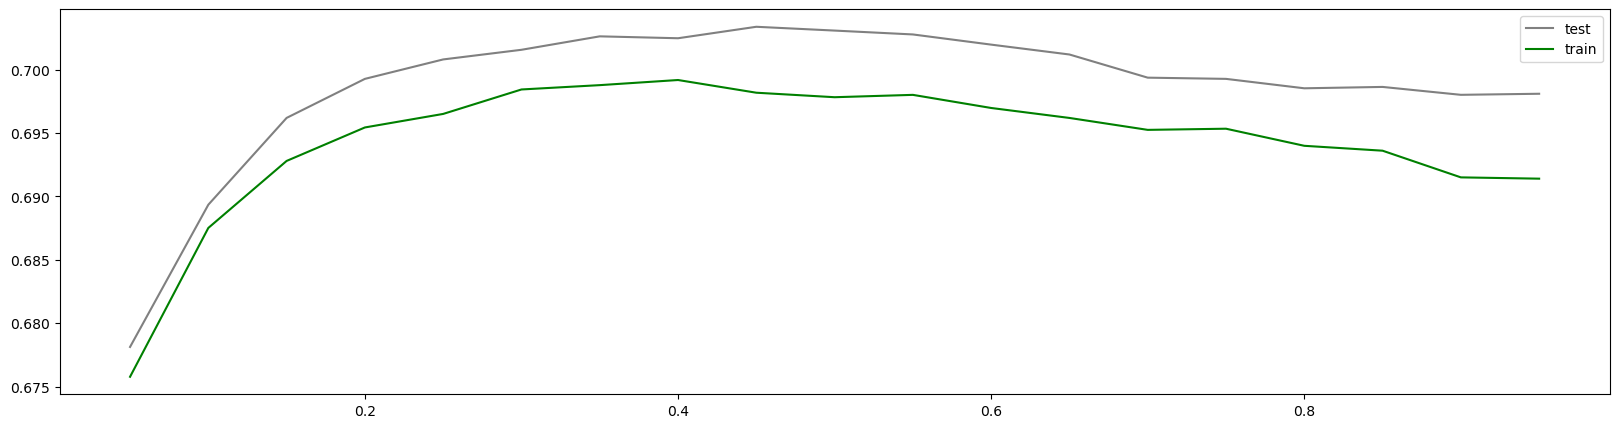

In [ ]:
# Cell 10: 特征重要性分析

# 获取特征重要性分数
feature_importance = xgb.feature_importances_

# 创建特征名称和重要性分数的DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
})

# 按重要性降序排序
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# 绘制特征重要性条形图
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance_df)), feature_importance_df['importance'])
plt.xticks(range(len(feature_importance_df)), feature_importance_df['feature'], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# 打印前10个最重要的特征
print('\nTop 10 Most Important Features:')
print(feature_importance_df.head(10))

In [ ]:
# Cell 11: 模型评估

try:
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(Y_test, y_pred))

    roc_auc = roc_auc_score(Y_test, y_pred_proba)
    print("Test ROC-AUC score:", roc_auc)
except Exception as e:
    print("Error during evaluation:", e)

In [ ]:
# Cell 12: 保存训练好的模型

import joblib

# 保存模型
joblib.dump(xgb_model, 'xgboost_model.joblib')

# 保存特征列名(用于后续预测时确保特征顺序一致)
feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.joblib')

print("模型和特征列名已保存")

In [82]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score